In [2]:
# Imports necesarios
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

In [3]:
# La fila 1 contiene el header
arr = np.loadtxt("tiempos.txt", skiprows=1)
#print(arr)

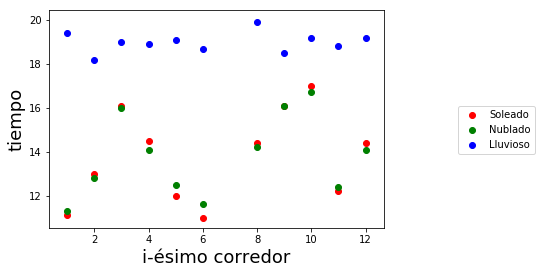

In [14]:
# Ploteamos los datos
soleado = arr[:,1]
nublado = arr[:,2]
lluvioso = arr[:,3]

fig = plt.figure()
scat_soleado = plt.scatter(arr[:,0], soleado, color="r")
scat_nublado = plt.scatter(arr[:,0], nublado, color="g")
scat_lluvioso = plt.scatter(arr[:,0], lluvioso, color="b")

plt.xlabel('i-ésimo corredor', fontsize=18)
plt.ylabel('tiempo', fontsize=18)

# Cuadro de Leyendas
fig.legend((scat_soleado,scat_nublado,scat_lluvioso), ('Soleado', 'Nublado', 'Lluvioso'), 'center right', bbox_to_anchor=(1.25, 0.5))

plt.show()

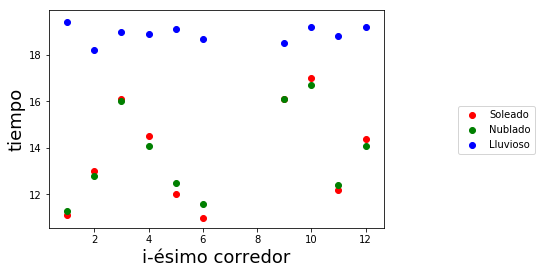

In [15]:
# El 7mo corredor parece ser outlier, por lo que se descarta y se vuelve a plotear los datos.

arr = np.delete(arr, 6,0)

soleado = arr[:,1]
nublado = arr[:,2]
lluvioso = arr[:,3]

fig = plt.figure()
scat_soleado = plt.scatter(arr[:,0], soleado, color="r")
scat_nublado = plt.scatter(arr[:,0], nublado, color="g")
scat_lluvioso = plt.scatter(arr[:,0], lluvioso, color="b")

plt.xlabel('i-ésimo corredor', fontsize=18)
plt.ylabel('tiempo', fontsize=18)

# Cuadro de Leyendas
fig.legend((scat_soleado,scat_nublado,scat_lluvioso), ('Soleado', 'Nublado', 'Lluvioso'), 'center right', bbox_to_anchor=(1.25, 0.5))

plt.show()

In [21]:
# Me fijo si descarto que son normales con Shapiro

print("Tests de normalidad")

_, norm_p1 = stats.shapiro(soleado)
_, norm_p2 = stats.shapiro(nublado)
_, norm_p3 = stats.shapiro(lluvioso)

print("Shapiro test: {}, {}, {}".format(norm_p1, norm_p2, norm_p3))

# No se puede rechazar que no tengan distribucion normal

print("Tests de misma varianza")

_, var_p = stats.levene(soleado, nublado, lluvioso)
_, var_p1 = stats.levene(soleado, nublado)
_, var_p2 = stats.levene(soleado, lluvioso)
_, var_p3 = stats.levene(nublado, lluvioso)

print("Levene test: {}".format(var_p))
print("Levene test 1v2: {}".format(var_p1))
print("Levene test 1v3: {}".format(var_p2))
print("Levene test 2v3: {}".format(var_p3))

# Tomando como 0.05 como alpha, se descarta la igualdad de la varianza entre los dias soleados y nublados contra los dias de lluvia.
# Para comprar soleados y nublados se puede utilizar t-test apareado, si se compran los dias de lluvia Welch t-test. En todos los casos se pueden utilizar tests no paramétricos como shuffle.

Tests de normalidad
Shapiro test: 0.42219114303588867, 0.3774447739124298, 0.9883151650428772
Tests de misma varianza
Levene test: 0.004061494634406996
Levene test 1v2: 0.6734363390373725
Levene test 1v3: 0.001922547526531154
Levene test 2v3: 0.0019301380767628243


In [ ]:
# - ITEM 1 -
print("Tests de misma media")

_, mean_p_1v2 = stats.ttest_ind(soleado, nublado, equal_var=False)
_, mean_p_1v3 = stats.ttest_ind(soleado, lluvioso, equal_var=False)
_, mean_p_2v3 = stats.ttest_ind(lluvioso, nublado, equal_var=False)

print("Welch's test 1v2: {}".format(mean_p_1v2))
print("Welch's test 1v3: {}".format(mean_p_1v3))
print("Welch's test 2v3: {}".format(mean_p_2v3))

def calcular_delta(d,e):
    mean_1_inicial = d[e == e[0]].mean()
    mean_2_inicial = d[e != e[0]].mean()

    delta = mean_2_inicial - mean_1_inicial

    return delta


def permutation_test(d,e, n=100000):
    d0 = calcular_delta(d,e)
    deltas = np.zeros(n)
    aux_e = e.copy()

    for i in range(n):
        np.random.shuffle(aux_e)
        deltas[i] = calcular_delta(d,aux_e)

    return deltas, d0

def foo(a, e_a, b, e_b):
    e_1 = np.full(a.shape[0], e_a) 
    e_2 = np.full(b.shape[0], e_b)
    e = np.concatenate((e_1,e_2)) 
    d = np.concatenate((a,b))
    return d,e

#Item 1 : "Los atletas son más lentos en dı́as de lluvia que en dı́as soleados." 
#H0 : los atletas tienen mayor o igual velocidad en dias lluviosos que en dias soleados (negacion del enunciado)
d,e = foo(soleado, 's', lluvioso, 'l')
deltas, d0 = permutation_test(d,e)
pvalue =  deltas[deltas >= d0].shape[0]/deltas.shape[0]
print(d0,pvalue)

delta_alpha = np.percentile(deltas, 95)

sns.distplot(deltas, norm_hist=False, kde=False)
sns.plt.axvline(x=d0, linewidth=1, color='red', linestyle="dotted")
sns.plt.axvline(x=delta_alpha, linewidth=1, color='g', linestyle="dotted")
sns.plt.show()

#Hay evidencia suficiente para rechazar H0 => son mas lentos (rechazamos la negacion)

In [ ]:
# Item 2 : "El cielo nublado no influye en los tiempos de los atletas."

# Welsh :NO SABEMOS USAR UNA COLA
_, mean_p_ge_1v3 = stats.ttest_ind(lluvioso, soleado,, equal_var=False)
print("Welch's test 1v3: {}".format(mean_p_ge_1v3))

# H0 : La media de tiempos es igual tanto si esta nublado como soleado

# Dado que no se puede rechazar que tengan distinta varianza (y que no presenten una distribucion normal) 
# Usamos el ttest apareado para intentar rechazar igual media 
_, pvalue = stats.ttest_rel(soleado, nublado)
print("Paired test soleado y nublado a dos colas: {}".format(pvalue))
# No se puede rechazar la igualdad de medias, no se llega a ninguna conclusion 

In [ ]:
# Item 3 : "La velocidad en dı́as de lluvia es independiente del atleta."
sns.plt.scatter(soleado,nublado)
pearson, pvalue = stats.pearsonr(soleado,nublado)
print("Coeficiente de pearson correlacion entre soleado y nublado: pearson: {}, pvalue: {}".format(pearson,pvalue))
sns.plt.show()

sns.plt.scatter(soleado,lluvioso)
pearson, pvalue = stats.pearsonr(soleado,lluvioso)
print("Coeficiente de pearson correlacion entre soleado y lluvioso: pearson: {}, pvalue: {}".format(pearson,pvalue))
sns.plt.show()

In [ ]:
# Item 4: just talk about previous results

In [ ]:
# Conclusions